In [9]:
# 0.0 import packages

import shutil
import os
import time
import sys
import string
import mido
import numpy as np
import pandas as pd

from scipy import signal
import audiosegment
import librosa
from tqdm import tqdm

import matplotlib.pyplot as plot

In [10]:
# 0.1 midi mappings from groove dataset
# kick drum
BASS = 36
# snare drum
SNARE_HEAD = 38
SNARE_RIM = 40
SNARE_X_STICK = 37
# toms
TOM_1_HEAD = 48
TOM_1_RIM = 50
TOM_2_HEAD = 45
TOM_2_RIM = 47
TOM_3_HEAD = 43
TOM_3_RIM = 58
# hi-hats
HH_OPEN_BOW = 46
HH_OPEN_EDGE = 26
HH_CLOSED_BOW = 42
HH_CLOSED_EDGE = 22
HH_PEDAL = 44
# crash cymbal
CRASH_1_BOW = 49
CRASH_1_EDGE = 55
CRASH_2_BOW = 57
CRASH_2_EDGE = 52
# ride cymbal
RIDE_BOW = 51
RIDE_EDGE = 59
RIDE_BELL = 53

# mappings for our own training (9)
KICK = 0
SNARE = 1
HH_CLOSED = 2
HH_OPEN = 3
RIDE = 4
TOM_1 = 5
TOM_2 = 6
TOM_3 = 7
CRASH = 8
NUM_FEATS = 9

# groove mappings to our mappings
KICK_LIST = [BASS]
SNARE_LIST = [SNARE_HEAD, SNARE_RIM, SNARE_X_STICK]
HH_CLOSED_LIST = [HH_CLOSED_BOW, HH_CLOSED_EDGE, HH_PEDAL]
HH_OPEN_LIST = [HH_OPEN_BOW, HH_OPEN_EDGE]
RIDE_LIST = [RIDE_BOW, RIDE_EDGE, RIDE_BELL]
TOM_1_LIST = [TOM_1_HEAD, TOM_1_RIM]
TOM_2_LIST = [TOM_2_HEAD, TOM_2_RIM]
TOM_3_LIST = [TOM_3_HEAD, TOM_3_RIM]
CRASH_LIST = [CRASH_1_BOW, CRASH_1_EDGE, CRASH_2_BOW, CRASH_2_EDGE]


In [11]:
# 1.0 load groove dataset

groove_csv = pd.read_csv('data/groove/info.csv')
print("groove dataset:", len(groove_csv))

# get train, test, and validation sets
train_csv = []
test_csv = []
validation_csv = []

for index, row in groove_csv.iterrows():
    if str(row.audio_filename).lower() != "nan":
        split = row['split']
        if split == "train":
            train_csv.append(row)
        elif split == "test":
            test_csv.append(row)
        elif split == "validation":
            validation_csv.append(row)
        
print ("train: ", len(train_csv))
print ("test: ", len(test_csv))
print ("validation: ", len(validation_csv))

groove dataset: 1150
train:  846
test:  124
validation:  120


In [12]:
# 1.1 code to convert midi file to array
# https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        value = 1 if velocity > 0 else 0
        result[note-21] = value if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2array(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    # sums = all_arys.sum(axis=1)
    # ends = np.where(sums > 0)[0]
    return all_arys #[min(ends): max(ends)]

In [22]:
# 2.0 functions for feature and label extraction

default_sample_rate = 44100

# resets temp folder
def reset_temp_folder():
    if os.path.isfile('temp/'):
        shutil.rmtree('temp/', ignore_errors=True)
    if not os.path.exists('temp/'):
        os.mkdir('temp/')

# converts an audio file to log mel array
def audio_to_melspec_array(wav_file_path, window_size, window_stride, sample_rate=default_sample_rate):
    n_dft = int(sample_rate * window_size)
    n_mels = 128
    win_length = 256
    hop_length = int(sample_rate * window_stride)
    # load in wav file and remove the mean of the signal
    y, sr = librosa.load(wav_file_path, sr=sample_rate)
    y = y - y.mean()
    y = np.append(y[0],y[1:]-.97*y[:-1])
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_dft, hop_length=hop_length, win_length=win_length, window=signal.hamming)
    spec = np.abs(stft)**2
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_dft, n_mels=n_mels, fmin=0)
    melspec = np.dot(mel_basis, spec)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    logspec = np.transpose(logspec)
    # plot.imshow(logspec.T, origin='lower', aspect='auto')
    # plot.show()
    # turn into tensor
    # logspec_tensor = torch.tensor(logspec)
    return logspec

# reformats midi array for training
def reformat_midi(midi_array):
    midi_array = midi_array.T # transpose midi array for easy access
    T_steps = midi_array.shape[1] # get number of time steps
    # kicks
    kick_midi = np.zeros((T_steps), dtype='int64')
    for val in KICK_LIST:
        kick_midi += midi_array[val-21]
    kick_midi = np.where(kick_midi > 0, 1, 0)
    # snares
    snare_midi = np.zeros((T_steps), dtype='int64')
    for val in SNARE_LIST:
        snare_midi += midi_array[val-21]
    snare_midi = np.where(snare_midi > 0, 1, 0)
    # hh_close
    hh_close_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_CLOSED_LIST:
        hh_close_midi += midi_array[val-21]
    hh_close_midi = np.where(hh_close_midi > 0, 1, 0)
    # hh_open
    hh_open_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_OPEN_LIST:
        hh_open_midi += midi_array[val-21]
    hh_open_midi = np.where(hh_open_midi > 0, 1, 0)
    # ride
    ride_midi = np.zeros((T_steps), dtype='int64')
    for val in RIDE_LIST:
        ride_midi += midi_array[val-21]
    ride_midi = np.where(ride_midi > 0, 1, 0)
    # tom 1
    tom1_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_1_LIST:
        tom1_midi += midi_array[val-21]
    tom1_midi = np.where(tom1_midi > 0, 1, 0)
    # tom 2
    tom2_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_2_LIST:
        tom2_midi += midi_array[val-21]
    tom2_midi = np.where(tom2_midi > 0, 1, 0)
    # tom 3
    tom3_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_3_LIST:
        tom3_midi += midi_array[val-21]
    tom3_midi = np.where(tom3_midi > 0, 1, 0)
    # crash
    crash_midi = np.zeros((T_steps), dtype='int64')
    for val in CRASH_LIST:
        crash_midi += midi_array[val-21]
    crash_midi = np.where(crash_midi > 0, 1, 0)
    
    reformated_midi_array = np.zeros((midi_array.shape[1], NUM_FEATS), dtype='int64')
    reformated_midi_array[:,KICK] = kick_midi
    reformated_midi_array[:,SNARE] = snare_midi
    reformated_midi_array[:,HH_CLOSED] = hh_close_midi
    reformated_midi_array[:,HH_OPEN] = hh_open_midi
    reformated_midi_array[:,RIDE] = ride_midi
    reformated_midi_array[:,TOM_1] = tom1_midi
    reformated_midi_array[:,TOM_2] = tom2_midi
    reformated_midi_array[:,TOM_3] = tom3_midi
    reformated_midi_array[:,CRASH] = crash_midi
    return reformated_midi_array

# shrinks an array down keeping the distance between values proportional
def shrink_array_proportionally(midi_array, target_resize):
    resized_array = np.zeros((target_resize, midi_array.shape[1]))
    ratio = midi_array.shape[0] / target_resize
    # iterate through each time-step
    for t in range(midi_array.shape[0]): 
        # for each value
        for i in range(midi_array.shape[1]):
            value = midi_array[t][i]
            if value > 0:
                t2 = int(t / ratio)
                resized_array[t2][i] = value
    return resized_array

# converts a midi array to a list of arrays
def midi_to_arrays(midi_array, num_arrays, array_length):
    midi_arrays = []
    split_midi_arrays = np.array_split(midi_array, num_arrays)
    #print ("midi array len: ", len(midi_array))
    #print ("split list len: ", len(split_midi_arrays))
    for i in range(len(split_midi_arrays)):
        #print ("shape: ", split_midi_arrays[i].shape)
        # only add array if correct size
        if split_midi_arrays[i].shape == (array_length, NUM_FEATS):
            midi_arrays.append(split_midi_arrays[i])
    return midi_arrays

# removes rows from midi_array if they are all 0
def cut_leading_ending_zeros(midi_array):
    # delete leading zeros
    leading_zeros = 0
    example = np.zeros(NUM_FEATS, dtype='int32')
    for t in range(midi_array.shape[0]):
        row = np.array(midi_array[t,:], dtype='int32')
        if np.array_equal(row, example):
            leading_zeros += 1
        else:
            break
    if leading_zeros > 0:
        midi_array = np.delete(midi_array, np.s_[0:leading_zeros], axis=0)
    # delete ending zeros
    ending_zeros = 0
    for t in range(midi_array.shape[0]-1, -1, -1):
        row = np.array(midi_array[t,:], dtype='int32')
        if np.array_equal(row, example):
            ending_zeros += 1
        else:
            break
    #print('ending zeros: ', ending_zeros, ' shape b4: ', midi_array.shape)
    if ending_zeros > 0:
        midi_array = midi_array[:-ending_zeros]
    #print('ending zeros: ', ending_zeros, ' shape after: ', midi_array.shape)
    return midi_array, leading_zeros, ending_zeros

# slice midi based on ticks per seg (x ticks = 1 segment index)
def slice_midi(midi_array, ticks_per_seg):
    # get midi segments
    midi_segments = []
    for t in range(0, midi_array.shape[0], ticks_per_seg):
        segment = np.zeros(NUM_FEATS, dtype='int32')
        for inst in range(NUM_FEATS):
            sum = 0
            for i in range(ticks_per_seg):
                if (t+i < midi_array.shape[0]):
                    sum += midi_array[t+i][inst]
            sum /= ticks_per_seg
            if (sum > 0.0):
                segment[inst] = 1
        midi_segments.append(segment)
    return midi_segments

def remove_leading_silence(wav_array):
    leading_silence = 0
    for t in range(len(wav_array)):
        if wav_array[t] == 0 or wav_array[t] == -1 or wav_array[t] == 1:
            leading_silence += 1
        else:
            break
    if leading_silence > 0:
        wav_array = wav_array[leading_silence:]
    return wav_array

# bbgiyfiy

def squish_midi_notes(midi_array):
    # for every feature type
    for i in range (midi_array.shape[1]):
        remove_preceding_1s = False
        # for every time frame
        for t in range(midi_array.shape[0]):
            if midi_array[t][i] == 1:
                if remove_preceding_1s:
                    midi_array[t][i] = 0
                else:
                    midi_array[t][i] = 1
                    remove_preceding_1s = True
            elif midi_array[t][i] == 0:
                if remove_preceding_1s:
                    remove_preceding_1s = False
        #print ('midi_array[', i, ']: ', midi_array[:,i])
    return midi_array
        
def show_midi_plot(midi_array):
    midi_array = np.flip(midi_array.T, axis=0)
    fig = plot.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    plot.imshow(midi_array, cmap='binary', interpolation='None', aspect="auto")
    plot.show()
    return fig
    
def show_spectrograph(spec_array):
    spec_array = np.flip(spec_array, axis=0)
    fig = plot.figure()
    fig.set_figwidth(20)
    fig.set_figheight(5)
    plot.imshow(spec_array, cmap='magma', interpolation='None', aspect="auto")
    plot.show()
    
def show_midi_over_spec(spec_array, midi_array):
    midi_array = np.flip(midi_array.T, axis=0)
    spec_array = np.flip(spec_array, axis=0)
    fig = plot.figure()
    fig.set_figwidth(20)
    fig.set_figheight(5)
    plot.imshow(spec_array, 'magma', interpolation='None', aspect="auto")
    plot.imshow(midi_array, 'binary', interpolation='None', alpha=0.5, aspect="auto")
    plot.show()

def get_data_segs(data_index, segment_length, mel_filters, n_fft, window_length, hop_length, print_out=False):
    # load in midi file
    midi_file_path = "data/groove/" + data_index.midi_filename
    midi = mido.MidiFile(midi_file_path)
    
    # convert midi to array
    midi_array = mid2array(midi)
    if print_out:
        show_midi_plot(midi_array)
    calculated_length = mido.tick2second(midi_array.shape[0], ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    # reformat midi array for training
    midi_array = reformat_midi(midi_array)
    if print_out:
        show_midi_plot(midi_array)
    # cut leading zeros
    midi_array, leading_zeros, ending_zeros = cut_leading_ending_zeros(midi_array)
    leading_removed = mido.tick2second(leading_zeros, ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    ending_removed = mido.tick2second(ending_zeros, ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    new_midi_duration = mido.tick2second(midi_array.shape[0], ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    if print_out:
        print ('starting length: ', midi.length)
        print ('calculated starting length: ', calculated_length)
        print ('leading removed: ', leading_removed)
        print ('ending removed: ', ending_removed)
        print ('new_midi duration: ', new_midi_duration)
        print ("removed starting zeros midi_array.shape: ", midi_array.shape)
        show_midi_plot(midi_array)
    # squish midi notes to be length of 1
    midi_array = squish_midi_notes(midi_array)
    if print_out:
        show_midi_plot(midi_array)
    # slice into segments of equal size
    ticks_per_sec = int(mido.second2tick(segment_length, ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm)))
    if print_out:
        print ('ticks per sec: ', ticks_per_sec)
    midi_segments = slice_midi(midi_array, ticks_per_sec)
    if print_out:
        print ('len(midi_segments): ', len(midi_segments))
    if print_out:
        show_midi_plot(np.array(midi_segments, dtype='int32'))




    # load in wav file
    audio_file_path = "data/groove/" + data_index.audio_filename
    wav_file = audiosegment.from_file(audio_file_path)
    if print_out:
        print ('wav file duration: ', wav_file.duration_seconds, ' framerate: ', wav_file.frame_rate)
    # convert sample width if not set to 2 (16 bits)
    if wav_file.sample_width != 2:
        wav_file = wav_file.set_sample_width(2)
        # print("\tnew sample_width: ", wav_file.sample_width)
        wav_file.export(audio_file_path, format="wav")
    # convert file from stereo to mono if channels > 1
    if wav_file.channels != 1:
        wav_file = wav_file.set_channels(1)
        wav_file.export(audio_file_path, format="wav")
    # remove starting silence from wav file
    wav_array = wav_file.to_numpy_array()
    wav_array = remove_leading_silence(wav_array)
    wav_file = audiosegment.from_numpy_array(wav_array, framerate=wav_file.frame_rate)
    if print_out:
        print ('new wav file duration: ', wav_file.duration_seconds)
    # cut wavfile to be same length in seconds as midi
    if wav_file.duration_seconds > new_midi_duration:
        resized_wav_file = wav_file.dice(new_midi_duration, zero_pad=False)
        wav_file = resized_wav_file[0]
        wav_file.export(audio_file_path, format="wav")
    
    # show wav file spec
    if print_out:
        wav_spec_array = wav_array - wav_array.mean()
        wav_spec_array = np.append(wav_spec_array[0],wav_spec_array[1:]-.97*wav_spec_array[:-1])
        # compute mel spectrogram
        wav_spec_array = librosa.stft(wav_spec_array, n_fft=n_fft, hop_length=hop_length, win_length=window_length, window=signal.hamming)
        wav_spec_array = np.abs(wav_spec_array)**2
        # mel spec log show
        mel_basis = librosa.filters.mel(sr=default_sample_rate, n_fft=n_fft, n_mels=mel_filters, fmin=0, fmax=20000)
        melspec = np.dot(mel_basis, wav_spec_array)
        logspec = librosa.power_to_db(melspec, ref=np.max)

        if print_out:
            plot.imshow(logspec, origin='lower', aspect='auto')
            plot.show()
    
    diced_wav_file = wav_file.dice(segment_length, zero_pad=True)
    while len(diced_wav_file) > len(midi_segments):
        diced_wav_file.pop()
    while len(midi_segments) > len(diced_wav_file):
        midi_segments.pop()
    # convert midi segments to np array
    midi_segments = np.array(midi_segments, dtype='int32')
    
    # apply mel filer to audio segments
    formated_audio = []
    for seg in diced_wav_file:
        seg_np = seg.to_numpy_array()
        seg_np = seg_np - seg_np.mean()
        seg_np = np.append(seg_np[0],seg_np[1:]-.97*seg_np[:-1])
        
        #print ('seg_np.shape: ', seg_np.shape)
        
        # compute mel spectrogram
        stft = librosa.stft(seg_np, n_fft=n_fft, hop_length=hop_length, win_length=window_length, window=signal.hamming)
        spec = np.abs(stft)**2
        
        #print ('spec.shape: ', spec.shape)
        
        mel_basis = librosa.filters.mel(sr=default_sample_rate, n_fft=n_fft, n_mels=mel_filters, fmin=0, fmax=20000)
        melspec = np.dot(mel_basis, spec)
        logspec = librosa.power_to_db(melspec, ref=np.max)
        
        #print ('logspec.shape: ', logspec.shape)
        
        if print_out:
            plot.imshow(logspec, origin='lower', aspect='equal')
            plot.show()

        formated_audio.append(logspec)
    formated_audio_array = np.array(formated_audio, dtype='float32')
    #print ('formated_audio_array.shape: ', formated_audio_array.shape)
    return formated_audio_array, midi_segments

  0%|          | 0/1 [00:00<?, ?it/s]

\n 0  file:  drummer1/session1/10_jazz-funk_116_fill_4-4.wav   1.872843 sec bpm:  116


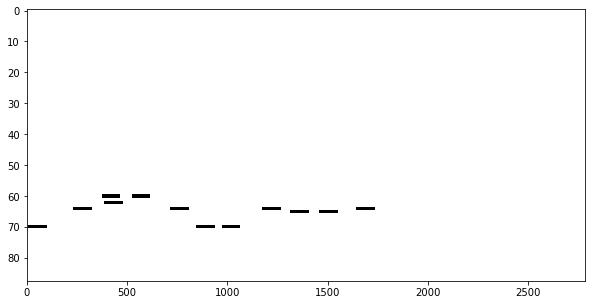

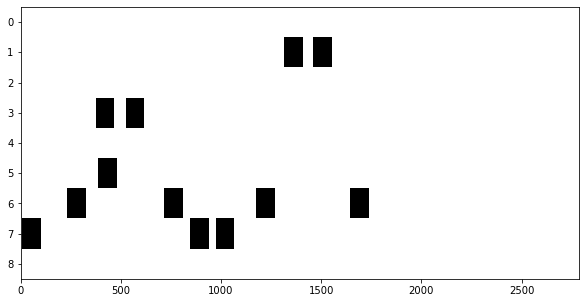

starting length:  3.0010753854166663
calculated starting length:  3.0010753854166663
leading removed:  0.006465512499999999
ending removed:  1.1282319312499998
new_midi duration:  1.8663779416666664
removed starting zeros midi_array.shape:  (1732, 9)


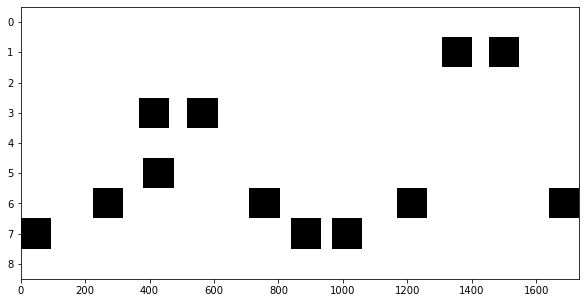

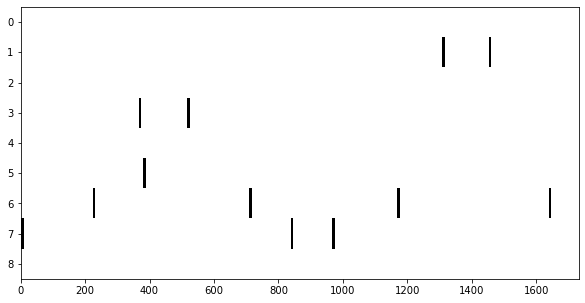

ticks per sec:  46
len(midi_segments):  38


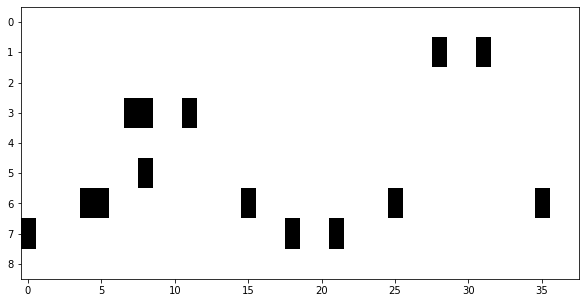

wav file duration:  1.8663718820861679  framerate:  44100
new wav file duration:  1.8663718820861679


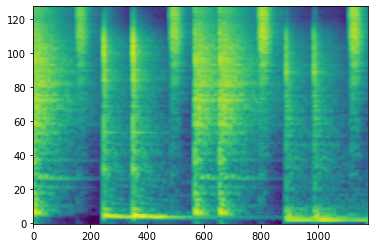

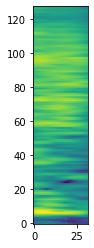

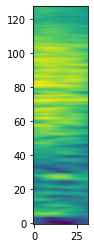

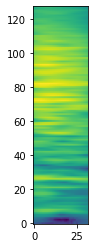

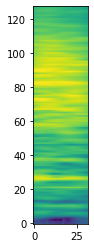

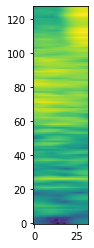

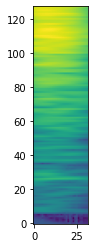

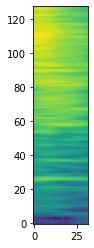

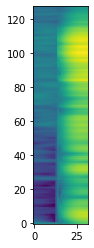

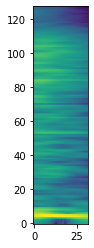

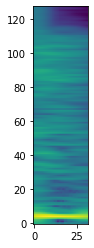

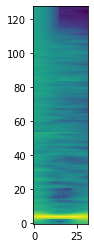

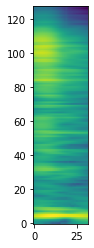

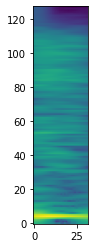

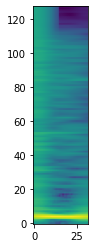

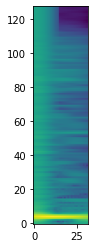

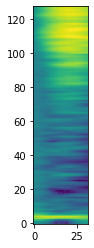

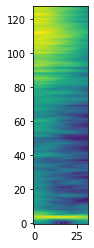

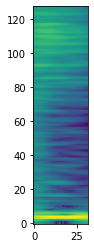

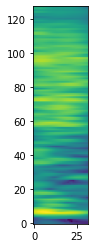

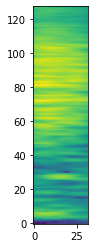

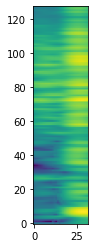

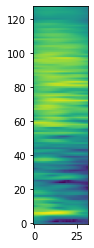

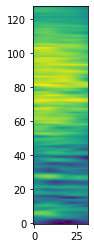

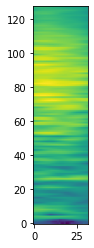

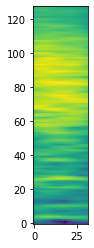

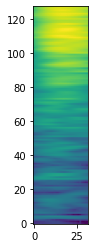

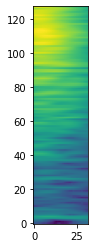

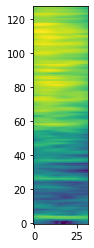

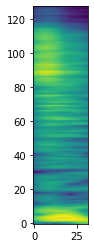

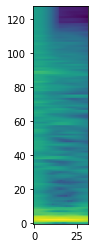

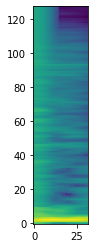

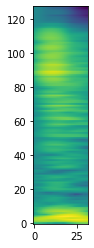

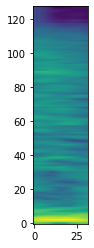

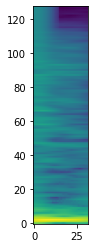

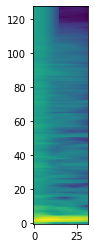

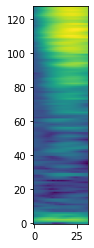

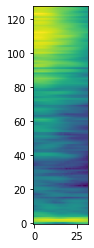

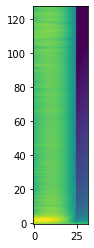

100%|██████████| 1/1 [00:02<00:00,  2.70s/it]

feats.shape:  (38, 128, 32)  labels.shape:  (38, 9)
train_feats.shape:  (38, 128, 32)
train_labels.shape:  (38, 9)
time elapsed:  2.7  sec



In [24]:
# {dev only}\n
    
np.set_printoptions(suppress=False)
np.set_printoptions(threshold=sys.maxsize)

DEV_MODE = True
# these values define the resolution of the data
SEGMENT_LEN = 0.05 # length of each segment in seconds 
N_FFT = 2048
WINDOW_LEN = 2048
HOP_LEN = 70
MEL_FILTERS = 128


if DEV_MODE:
    # get complete list of train feats / labels
    
    dev_csv = []
    dev_csv.append(train_csv[1])
    
    startTime = time.time()
    feats_list = []
    labels_list = []

    for i, index in enumerate(tqdm(dev_csv)):
        print ('\\n', i, " file: ", index.audio_filename, " ", index.duration, "sec bpm: ", index.bpm)
        feats, labels = get_data_segs(index, SEGMENT_LEN, MEL_FILTERS, N_FFT, WINDOW_LEN, HOP_LEN, print_out=True)
        print ('feats.shape: ', feats.shape, ' labels.shape: ', labels.shape)
        if (feats.shape[0] == labels.shape[0]):
            for j in range(len(feats)):
                # print (\"\\t\", j, \" feats: \", feats[j].shape, \" labels: \", labels[j].shape)
                # show_midi_plot(labels[j])
                # show_spectrograph(feats[j])
                # show_midi_over_spec(feats[j], labels[j])
                # print ('feats: ', feats)
                # print ('labels: ', labels)
                feats_list.append(feats[j])
                labels_list.append(labels[j])
    # make into numpy arrays
    feats_array = np.array(feats_list, dtype='float64')
    labels_array = np.array(labels_list, dtype='int64')
    print ("train_feats.shape: ", feats_array.shape)
    print ("train_labels.shape: ", labels_array.shape)
    # dataset complete
    print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")

In [15]:
# 3.0 run dataset creation loops - save to file

np.set_printoptions(threshold=sys.maxsize)

# data id (used to make different datasets)
data_id = '_64mel_32frames_0.1sec'
print ("DATASET ID: ", data_id)

# these values define the resolution of the data
SEGMENT_LEN = 0.1 # length of each segment in seconds 
N_FFT = 2048
WINDOW_LEN = 2048
HOP_LEN = 280
MEL_FILTERS = 64
    

# reset temp folder
reset_temp_folder()

#########################################
#                                       #
#           TRAINING DATA               #
#                                       #
#########################################

# get complete list of train feats / labels
print ("starting training dataset creation...")
startTime = time.time()
train_feats = []
train_labels = []

for i, index in enumerate(tqdm(train_csv)):
    # print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = get_data_segs(index, SEGMENT_LEN, MEL_FILTERS, N_FFT, WINDOW_LEN, HOP_LEN, print_out=False)
    for j in range(len(feats)):
        # print ("\t", j, " feats: ", feats[j].shape, " labels: ", labels[j].shape)
        # show_midi_plot(labels[j])
        # show_spectrograph(feats[j])
        # show_midi_over_spec(feats[j], labels[j])
        train_feats.append(feats[j])
        train_labels.append(labels[j])
# make into numpy arrays
train_feats = np.array(train_feats, dtype='float32')
train_labels = np.array(train_labels, dtype='int32')
print ("train_feats.shape: ", train_feats.shape)
print ("train_labels.shape: ", train_labels.shape)
# dataset complete
print ("training dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# create dataset folder if it does not exist
if not os.path.exists('data/dataset' + data_id):
        os.mkdir('data/dataset' + data_id)
# save feats / labels lists to file
np.save("data/dataset" + data_id + "/" + "train_feats" + data_id + ".npy", train_feats, allow_pickle=True)
np.save("data/dataset" + data_id + "/" + "train_labels" + data_id + ".npy", train_labels, allow_pickle=True)

#########################################
#                                       #
#               TEST DATA               #
#                                       #
#########################################

# get complete list of test feats / labels
print ("starting test dataset creation...")
startTime = time.time()
test_feats = []
test_labels = []
for i, index in enumerate(tqdm(test_csv)):
    #print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = get_data_segs(index, SEGMENT_LEN, MEL_FILTERS, N_FFT, WINDOW_LEN, HOP_LEN, print_out=False)
    for j in range(len(feats)):
        # show_midi_over_spec(feats[j], labels[j])
        test_feats.append(feats[j])
        test_labels.append(labels[j])
# make into numpy arrays
test_feats = np.array(test_feats, dtype='float32')
test_labels = np.array(test_labels, dtype='int32')
print ("test_feats.shape: ", test_feats.shape)
print ("test_labels.shape: ", test_labels.shape)
# dataset complete
print ("test dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# save feats / labels lists to file
np.save("data/dataset" + data_id + "/" + "test_feats" + data_id + ".npy", test_feats, allow_pickle=True)
np.save("data/dataset" + data_id + "/" + "test_labels" + data_id + ".npy", test_labels, allow_pickle=True)

#########################################
#                                       #
#           VALIDATION DATA             #
#                                       #
#########################################

# # get complete list of validation feats / labels
print ("starting validation dataset creation...")
startTime = time.time()
val_feats = []
val_labels = []
for i, index in enumerate(tqdm(validation_csv)):
    #print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = get_data_segs(index, SEGMENT_LEN, MEL_FILTERS, N_FFT, WINDOW_LEN, HOP_LEN, print_out=False)
    for j in range(len(feats)):
        # show_midi_over_spec(feats[j], labels[j])
        val_feats.append(feats[j])
        val_labels.append(labels[j])
# make into numpy arrays
val_feats = np.array(val_feats, dtype='float32')
val_labels = np.array(val_labels, dtype='int32')
print ("val_feats.shape: ", val_feats.shape)
print ("val_labels.shape: ", val_labels.shape)
# dataset complete
print ("validation dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# save feats / labels lists to file
np.save("data/dataset" + data_id + "/" + "val_feats" + data_id + ".npy", val_feats, allow_pickle=True)
np.save("data/dataset" + data_id + "/" + "val_labels" + data_id + ".npy", val_labels, allow_pickle=True)

# reset temp folder
reset_temp_folder()

DATASET ID:  _64mel_32frames_0.1sec
starting training dataset creation...


  0%|          | 4/846 [00:14<52:11,  3.72s/it]


KeyboardInterrupt: 